#A Mechanistic Interpretability Analysis of Grokking - 5 Digit Addition
This workbook includes content from:

* [A Mechanistic Interpretability Analysis of Grokking (Stable)](https://colab.research.google.com/drive/1F6_1_cWXE5M7WocUcpQWp3v8z4b1jL20#scrollTo=XdjjunLxwi_b) - the "Experiment: Task 2: 5 Digit Addition" overview section.
* [A-mechanistic-interpretability-analysis-of-grokking#Speculation__Phase_Changes_are_Everywhere](https://www.alignmentforum.org/posts/N6WM6hs7RQMKDhYjB/) - the discussion "Problem Statement: What causes the digit phasing timing differences?"  
* [Non_Modular_Addition_Grokking_Tasks.ipynb](https://github.com/mechanistic-interpretability-grokking/progress-measures-paper/blob/main/Non_Modular_Addition_Grokking_Tasks%20(1).ipynb) - the sections to run the model.

PQ's original context on explaining the model is in [Towards Interpretability of 5 digit addition](https://docs.google.com/document/d/1wsNrxFWCC4De2lUla7dkKs5iAZ_qtVli9bOAnGFkS9U/edit) but was moved to and improved in [Addition Interpretability Cohort3 - OverLeaf](https://www.overleaf.com/project/64c75f5e7211fe5cb86623d2). This CoLab contains, in sections containing "PQ", the implementation of the experiments detailed in the Overleaf paper.

# A Mechanistic Interpretability Analysis of Grokking: Setup (Mandatory)
A collection of helper functions and setup code, no need to read.

In [1]:
use_drive = False #@param

In [2]:
!nvidia-smi
!pip install einops

Thu Aug 17 21:23:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
import tqdm.notebook as tqdm

import random
import time

from google.colab import drive
from pathlib import Path
import pickle
import os

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "colab"
import plotly.graph_objects as go

from torch.utils.data import DataLoader

from functools import *
import pandas as pd
import gc

# import comet_ml
import itertools

Download all the cached files needed to run this notebook. The full run data (incl 500 checkpoints) for the modular addition run is too big for Github, so it's downloaded from Google Drive.

In [4]:
!git clone https://github.com/neelnanda-io/Grokking.git
root = Path('/content/Grokking/saved_runs')
large_root = Path('/content/Grokking/large_files')
try:
    os.mkdir(large_root)
except:
    pass
!pip install gdown
!gdown 12pmgxpTHLDzSNMbMCuAMXP1lE_XiCQRy -O /content/Grokking/large_files/full_run_data.pth

#Note to self - to commit, run git add .; git config --global user.email "neelnanda27@gmail.com"; git config --global user.name "Neel Nanda"; git commit -m "Message"; git push

fatal: destination path 'Grokking' already exists and is not an empty directory.
Downloading...
From: https://drive.google.com/uc?id=12pmgxpTHLDzSNMbMCuAMXP1lE_XiCQRy
To: /content/Grokking/large_files/full_run_data.pth
100% 456M/456M [00:02<00:00, 178MB/s]


In [5]:

if use_drive:
    drive.mount('/content/gdrive')
    drive_root = Path('/content/gdrive/MyDrive/Colab Notebooks/Grok/')

##Defining Transformer

In [6]:
# A helper class to get access to intermediate activations (inspired by Garcon)
# It's a dummy module that is the identity function by default
# I can wrap any intermediate activation in a HookPoint and get a convenient
# way to add PyTorch hooks
class HookPoint(nn.Module):
    def __init__(self):
        super().__init__()
        self.fwd_hooks = []
        self.bwd_hooks = []

    def give_name(self, name):
        # Called by the model at initialisation
        self.name = name

    def add_hook(self, hook, dir='fwd'):
        # Hook format is fn(activation, hook_name)
        # Change it into PyTorch hook format (this includes input and output,
        # which are the same for a HookPoint)
        def full_hook(module, module_input, module_output):
            return hook(module_output, name=self.name)
        if dir=='fwd':
            handle = self.register_forward_hook(full_hook)
            self.fwd_hooks.append(handle)
        elif dir=='bwd':
            handle = self.register_backward_hook(full_hook)
            self.bwd_hooks.append(handle)
        else:
            raise ValueError(f"Invalid direction {dir}")

    def remove_hooks(self, dir='fwd'):
        if (dir=='fwd') or (dir=='both'):
            for hook in self.fwd_hooks:
                hook.remove()
            self.fwd_hooks = []
        if (dir=='bwd') or (dir=='both'):
            for hook in self.bwd_hooks:
                hook.remove()
            self.bwd_hooks = []
        if dir not in ['fwd', 'bwd', 'both']:
            raise ValueError(f"Invalid direction {dir}")

    def forward(self, x):
        return x

In [7]:
# Define network architecture
# I defined my own transformer from scratch so I'd fully understand each component
# - I expect this wasn't necessary or particularly important, and a bunch of this
# replicates existing PyTorch functionality

# Embed & Unembed
class Embed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_E = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_model))

    def forward(self, x):
        return torch.einsum('dbp -> bpd', self.W_E[:, x])

class Unembed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_U = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_vocab))

    def forward(self, x):
        return (x @ self.W_U)

# Positional Embeddings
class PosEmbed(nn.Module):
    def __init__(self, max_ctx, d_model):
        super().__init__()
        self.W_pos = nn.Parameter(torch.randn(max_ctx, d_model)/np.sqrt(d_model))

    def forward(self, x):
        return x+self.W_pos[:x.shape[-2]]

# LayerNorm
class LayerNorm(nn.Module):
    def __init__(self, d_model, epsilon = 1e-4, model=[None]):
        super().__init__()
        self.model = model
        self.w_ln = nn.Parameter(torch.ones(d_model))
        self.b_ln = nn.Parameter(torch.zeros(d_model))
        self.epsilon = epsilon

    def forward(self, x):
        if self.model[0].use_ln:
            x = x - x.mean(axis=-1)[..., None]
            x = x / (x.std(axis=-1)[..., None] + self.epsilon)
            x = x * self.w_ln
            x = x + self.b_ln
            return x
        else:
            return x

# Attention
class Attention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, n_ctx, model):
        super().__init__()
        self.model = model
        self.W_K = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_Q = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_V = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_O = nn.Parameter(torch.randn(d_model, d_head * num_heads)/np.sqrt(d_model))
        self.register_buffer('mask', torch.tril(torch.ones((n_ctx, n_ctx))))
        self.d_head = d_head
        self.hook_k = HookPoint()
        self.hook_q = HookPoint()
        self.hook_v = HookPoint()
        self.hook_z = HookPoint()
        self.hook_attn = HookPoint()
        self.hook_attn_pre = HookPoint()

    def forward(self, x):
        k = self.hook_k(torch.einsum('ihd,bpd->biph', self.W_K, x))
        q = self.hook_q(torch.einsum('ihd,bpd->biph', self.W_Q, x))
        v = self.hook_v(torch.einsum('ihd,bpd->biph', self.W_V, x))
        attn_scores_pre = torch.einsum('biph,biqh->biqp', k, q)
        attn_scores_masked = torch.tril(attn_scores_pre) - 1e10 * (1 - self.mask[:x.shape[-2], :x.shape[-2]])
        attn_matrix = self.hook_attn(F.softmax(self.hook_attn_pre(attn_scores_masked/np.sqrt(self.d_head)), dim=-1))
        z = self.hook_z(torch.einsum('biph,biqp->biqh', v, attn_matrix))
        z_flat = einops.rearrange(z, 'b i q h -> b q (i h)')
        out = torch.einsum('df,bqf->bqd', self.W_O, z_flat)
        return out

# MLP Layers
class MLP(nn.Module):
    def __init__(self, d_model, d_mlp, act_type, model):
        super().__init__()
        self.model = model
        self.W_in = nn.Parameter(torch.randn(d_mlp, d_model)/np.sqrt(d_model))
        self.b_in = nn.Parameter(torch.zeros(d_mlp))
        self.W_out = nn.Parameter(torch.randn(d_model, d_mlp)/np.sqrt(d_model))
        self.b_out = nn.Parameter(torch.zeros(d_model))
        self.act_type = act_type
        # self.ln = LayerNorm(d_mlp, model=self.model)
        self.hook_pre = HookPoint()
        self.hook_post = HookPoint()
        assert act_type in ['ReLU', 'GeLU']

    def forward(self, x):
        x = self.hook_pre(torch.einsum('md,bpd->bpm', self.W_in, x) + self.b_in)
        if self.act_type=='ReLU':
            x = F.relu(x)
        elif self.act_type=='GeLU':
            x = F.gelu(x)
        x = self.hook_post(x)
        x = torch.einsum('dm,bpm->bpd', self.W_out, x) + self.b_out
        return x

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model):
        super().__init__()
        self.model = model
        # self.ln1 = LayerNorm(d_model, model=self.model)
        self.attn = Attention(d_model, num_heads, d_head, n_ctx, model=self.model)
        # self.ln2 = LayerNorm(d_model, model=self.model)
        self.mlp = MLP(d_model, d_mlp, act_type, model=self.model)
        self.hook_attn_out = HookPoint()
        self.hook_mlp_out = HookPoint()
        self.hook_resid_pre = HookPoint()
        self.hook_resid_mid = HookPoint()
        self.hook_resid_post = HookPoint()

    def forward(self, x):
        x = self.hook_resid_mid(x + self.hook_attn_out(self.attn((self.hook_resid_pre(x)))))
        x = self.hook_resid_post(x + self.hook_mlp_out(self.mlp((x))))
        return x

# Full transformer
class Transformer(nn.Module):
    def __init__(self, num_layers, d_vocab, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, use_cache=False, use_ln=True):
        super().__init__()
        self.cache = {}
        self.use_cache = use_cache

        self.embed = Embed(d_vocab, d_model)
        self.pos_embed = PosEmbed(n_ctx, d_model)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model=[self]) for i in range(num_layers)])
        # self.ln = LayerNorm(d_model, model=[self])
        self.unembed = Unembed(d_vocab, d_model)
        self.use_ln = use_ln

        for name, module in self.named_modules():
            if type(module)==HookPoint:
                module.give_name(name)

    def forward(self, x):
        x = self.embed(x)
        x = self.pos_embed(x)
        for block in self.blocks:
            x = block(x)
        # x = self.ln(x)
        x = self.unembed(x)
        return x

    def set_use_cache(self, use_cache):
        self.use_cache = use_cache

    def hook_points(self):
        return [module for name, module in self.named_modules() if 'hook' in name]

    def remove_all_hooks(self):
        for hp in self.hook_points():
            hp.remove_hooks('fwd')
            hp.remove_hooks('bwd')

    def cache_all(self, cache, incl_bwd=False):
        # Caches all activations wrapped in a HookPoint
        def save_hook(tensor, name):
            cache[name] = tensor.detach()
        def save_hook_back(tensor, name):
            cache[name+'_grad'] = tensor[0].detach()
        for hp in self.hook_points():
            hp.add_hook(save_hook, 'fwd')
            if incl_bwd:
                hp.add_hook(save_hook_back, 'bwd')

##Helper Functions

In [8]:
# Helper functions
def cuda_memory():
    print(torch.cuda.memory_allocated()/1e9)

def cross_entropy_high_precision(logits, labels):
    # Shapes: batch x vocab, batch
    # Cast logits to float64 because log_softmax has a float32 underflow on overly
    # confident data and can only return multiples of 1.2e-7 (the smallest float x
    # such that 1+x is different from 1 in float32). This leads to loss spikes
    # and dodgy gradients
    logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
    prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
    loss = -torch.mean(prediction_logprobs)
    return loss

def full_loss(model, data):
    # Take the final position only
    logits = model(data)[:, -1]
    labels = torch.tensor([fn(i, j) for i, j, _ in data]).to('cuda')
    return cross_entropy_high_precision(logits, labels)

def test_logits(logits, bias_correction=False, original_logits=None, mode='all'):
    # Calculates cross entropy loss of logits representing a batch of all p^2
    # possible inputs
    # Batch dimension is assumed to be first
    if logits.shape[1]==p*p:
        logits = logits.T
    if logits.shape==torch.Size([p*p, p+1]):
        logits = logits[:, :-1]
    logits = logits.reshape(p*p, p)
    if bias_correction:
        # Applies bias correction - we correct for any missing bias terms,
        # independent of the input, by centering the new logits along the batch
        # dimension, and then adding the average original logits across all inputs
        logits = einops.reduce(original_logits - logits, 'batch ... -> ...', 'mean') + logits
    if mode=='train':
        return cross_entropy_high_precision(logits[is_train], labels[is_train])
    elif mode=='test':
        return cross_entropy_high_precision(logits[is_test], labels[is_test])
    elif mode=='all':
        return cross_entropy_high_precision(logits, labels)

In [9]:
#Plotting functions
# This is mostly a bunch of over-engineered mess to hack Plotly into producing
# the pretty pictures I want, I recommend not reading too closely unless you
# want Plotly hacking practice
def to_numpy(tensor, flat=False):
    if type(tensor)!=torch.Tensor:
        return tensor
    if flat:
        return tensor.flatten().detach().cpu().numpy()
    else:
        return tensor.detach().cpu().numpy()
def imshow(tensor, xaxis=None, yaxis=None, animation_name='Snapshot', **kwargs):
    if tensor.shape[0]==p*p:
        tensor = unflatten_first(tensor)
    tensor = torch.squeeze(tensor)
    px.imshow(to_numpy(tensor, flat=False),
              labels={'x':xaxis, 'y':yaxis, 'animation_name':animation_name},
              **kwargs).show()
# Set default colour scheme
imshow = partial(imshow, color_continuous_scale='Blues')
# Creates good defaults for showing divergent colour scales (ie with both
# positive and negative values, where 0 is white)
imshow_div = partial(imshow, color_continuous_scale='RdBu', color_continuous_midpoint=0.0)
# Presets a bunch of defaults to imshow to make it suitable for showing heatmaps
# of activations with x axis being input 1 and y axis being input 2.
inputs_heatmap = partial(imshow, xaxis='Input 1', yaxis='Input 2', color_continuous_scale='RdBu', color_continuous_midpoint=0.0)
def line(x, y=None, hover=None, xaxis='', yaxis='', **kwargs):
    if type(y)==torch.Tensor:
        y = to_numpy(y, flat=True)
    if type(x)==torch.Tensor:
        x=to_numpy(x, flat=True)
    fig = px.line(x, y=y, hover_name=hover, **kwargs)
    fig.update_layout(xaxis_title=xaxis, yaxis_title=yaxis)
    fig.show()
def scatter(x, y, **kwargs):
    px.scatter(x=to_numpy(x, flat=True), y=to_numpy(y, flat=True), **kwargs).show()
def lines(lines_list, x=None, mode='lines', labels=None, xaxis='', yaxis='', title = '', log_y=False, hover=None, **kwargs):
    # Helper function to plot multiple lines
    if type(lines_list)==torch.Tensor:
        lines_list = [lines_list[i] for i in range(lines_list.shape[0])]
    if x is None:
        x=np.arange(len(lines_list[0]))
    fig = go.Figure(layout={'title':title})
    fig.update_xaxes(title=xaxis)
    fig.update_yaxes(title=yaxis)
    for c, line in enumerate(lines_list):
        if type(line)==torch.Tensor:
            line = to_numpy(line)
        if labels is not None:
            label = labels[c]
        else:
            label = c
        fig.add_trace(go.Scatter(x=x, y=line, mode=mode, name=label, hovertext=hover, **kwargs))
    if log_y:
        fig.update_layout(yaxis_type="log")
    fig.show()
def line_marker(x, **kwargs):
    lines([x], mode='lines+markers', **kwargs)
def animate_lines(lines_list, snapshot_index = None, snapshot='snapshot', hover=None, xaxis='x', yaxis='y', **kwargs):
    if type(lines_list)==list:
        lines_list = torch.stack(lines_list, axis=0)
    lines_list = to_numpy(lines_list, flat=False)
    if snapshot_index is None:
        snapshot_index = np.arange(lines_list.shape[0])
    if hover is not None:
        hover = [i for j in range(len(snapshot_index)) for i in hover]
    print(lines_list.shape)
    rows=[]
    for i in range(lines_list.shape[0]):
        for j in range(lines_list.shape[1]):
            rows.append([lines_list[i][j], snapshot_index[i], j])
    df = pd.DataFrame(rows, columns=[yaxis, snapshot, xaxis])
    px.line(df, x=xaxis, y=yaxis, animation_frame=snapshot, range_y=[lines_list.min(), lines_list.max()], hover_name=hover,**kwargs).show()

def animate_multi_lines(lines_list, y_index=None, snapshot_index = None, snapshot='snapshot', hover=None, swap_y_animate=False, **kwargs):
    # Can plot an animation of lines with multiple lines on the plot.
    if type(lines_list)==list:
        lines_list = torch.stack(lines_list, axis=0)
    lines_list = to_numpy(lines_list, flat=False)
    if swap_y_animate:
        lines_list = lines_list.transpose(1, 0, 2)
    if snapshot_index is None:
        snapshot_index = np.arange(lines_list.shape[0])
    if y_index is None:
        y_index = [str(i) for i in range(lines_list.shape[1])]
    if hover is not None:
        hover = [i for j in range(len(snapshot_index)) for i in hover]
    print(lines_list.shape)
    rows=[]
    for i in range(lines_list.shape[0]):
        for j in range(lines_list.shape[2]):
            rows.append(list(lines_list[i, :, j])+[snapshot_index[i], j])
    df = pd.DataFrame(rows, columns=y_index+[snapshot, 'x'])
    px.line(df, x='x', y=y_index, animation_frame=snapshot, range_y=[lines_list.min(), lines_list.max()], hover_name=hover, **kwargs).show()

def animate_scatter(lines_list, snapshot_index = None, snapshot='snapshot', hover=None, yaxis='y', xaxis='x', color=None, color_name = 'color', **kwargs):
    # Can plot an animated scatter plot
    # lines_list has shape snapshot x 2 x line
    if type(lines_list)==list:
        lines_list = torch.stack(lines_list, axis=0)
    lines_list = to_numpy(lines_list, flat=False)
    if snapshot_index is None:
        snapshot_index = np.arange(lines_list.shape[0])
    if hover is not None:
        hover = [i for j in range(len(snapshot_index)) for i in hover]
    if color is None:
        color = np.ones(lines_list.shape[-1])
    if type(color)==torch.Tensor:
        color = to_numpy(color)
    if len(color.shape)==1:
        color = einops.repeat(color, 'x -> snapshot x', snapshot=lines_list.shape[0])
    print(lines_list.shape)
    rows=[]
    for i in range(lines_list.shape[0]):
        for j in range(lines_list.shape[2]):
            rows.append([lines_list[i, 0, j].item(), lines_list[i, 1, j].item(), snapshot_index[i], color[i, j]])
    print([lines_list[:, 0].min(), lines_list[:, 0].max()])
    print([lines_list[:, 1].min(), lines_list[:, 1].max()])
    df = pd.DataFrame(rows, columns=[xaxis, yaxis, snapshot, color_name])
    px.scatter(df, x=xaxis, y=yaxis, animation_frame=snapshot, range_x=[lines_list[:, 0].min(), lines_list[:, 0].max()], range_y=[lines_list[:, 1].min(), lines_list[:, 1].max()], hover_name=hover, color=color_name, **kwargs).show()

In [10]:
def unflatten_first(tensor):
    if tensor.shape[0]==p*p:
        return einops.rearrange(tensor, '(x y) ... -> x y ...', x=p, y=p)
    else:
        return tensor
def cos(x, y):
    return (x.dot(y))/x.norm()/y.norm()
def mod_div(a, b):
    return (a*pow(b, p-2, p))%p
def normalize(tensor, axis=0):
    return tensor/(tensor).pow(2).sum(keepdim=True, axis=axis).sqrt()
def extract_freq_2d(tensor, freq):
    # Takes in a pxpx... or batch x ... tensor, returns a 3x3x... tensor of the
    # Linear and quadratic terms of frequency freq
    tensor = unflatten_first(tensor)
    # Extracts the linear and quadratic terms corresponding to frequency freq
    index_1d = [0, 2*freq-1, 2*freq]
    # Some dumb manipulation to use fancy array indexing rules
    # Gets the rows and columns in index_1d
    return tensor[[[i]*3 for i in index_1d], [index_1d]*3]
def get_cov(tensor, norm=True):
    # Calculate covariance matrix
    if norm:
        tensor = normalize(tensor, axis=1)
    return tensor @ tensor.T
def is_close(a, b):
    return ((a-b).pow(2).sum()/(a.pow(2).sum().sqrt())/(b.pow(2).sum().sqrt())).item()

# A Mechanistic Interpretability Analysis of Grokking: Historic Experiments (Optional)
This section loads and graphs historic data. Running it is optional

####Task 2: 5 Digit Addition.

A 1L Transformer was trained on the problem of 5 digit addition, with inputs of the form `1 2 3 4 5 + 6 7 8 9 0 = 8 0 2 3 5` (where each digit and sign is a separate token).

In the graph for infinite data (batch size 256, AdamW, weight_decay=0.5), **we observe several clear phase changes in the train loss**


In [11]:
infinite_dic = torch.load(root/'5_digit_addition_infinite.pth')
train_losses = infinite_dic['train_losses']
line(train_losses,
     log_y=True,
     title='Phase Change in 5 Digit Addition Infinite Data Training Curve',
     xaxis='Steps',
     yaxis='Loss')

**When we train on 700 data points we observe clear grokking** (found by binary searching on the number of data points required for generalisation). Notably, the model groks a circuit that results in good performance on the test data (loss=0.2) despite achieving *far* better loss on the training data (loss=4e-8)

Note also that the training loss drops after grokking (4e-8 to 2.5e-8), showing that though there is still significant memorisation, it's now "more efficient"

In [12]:
finite_dic = torch.load(root/'5_digit_addition_finite.pth')
train_losses = finite_dic['train_losses']
test_losses = finite_dic['test_losses']
lines([train_losses, test_losses],
     log_y=True,
      labels=['train', 'test'],
     title='Phase Change in 5 Digit Addition Finite Data Training Curve (Log Scale)',
     xaxis='Epochs',
     yaxis='Loss')
lines([train_losses, test_losses],
     log_y=False,
      labels=['train', 'test'],
     title='Phase Change in 5 Digit Addition Finite Data Training Curve (Linear Scale)',
     xaxis='Epochs',
     yaxis='Loss')

I have not yet interpreted what's going on inside the model and whether there are crisp circuits, but it seems pretty likely. There are several phase changes in the infinite data case, suggesting the model learns several crisp circuits at different points in training.

~Notably, there's a small phase change in the infinite data case where the model likely learns to carry the one (around epoch=600, where $loss\approx \log(2)\times\frac{5}{6}=0.577$, the optimal loss achievable without being able to carry the 1). I find this incredibly cute <3 (though the finite data model does not seem to exhibit this phase change in the test loss)~
EDIT: These phase changes actually come from a phase change in the model's ability to calculate each digit.

# Speculation__Phase_Changes_are_Everywhere (Optional)

## What causes the digit phasing timing differences?

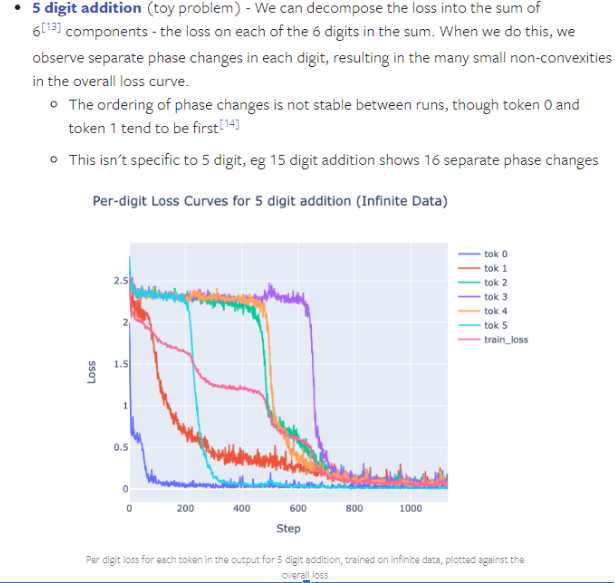



The above graph can be reproduced by running the below model with Infinite=True

# Non_Modular_Addition_Grokking_Tasks - Configuration (Mandatory)
Parameter configuration that controls training/test data and model training.

In [13]:
is_finite = False #@param

train_model = True #@param

# Optional. Performs on sanity checks of a percentage of the data. Slows processing a tad.
unit_tests = False #@param


In [14]:
#@markdown Model
num_layers = 1
d_vocab = 12
d_vocab_out = 10
d_model = 512 #@param
num_heads = 4
d_head = d_model//num_heads
d_mlp = 4 * d_model
seed = 129000 #@param
#@markdown Data
num_digits = 5 #@param
n_ctx = 3*num_digits + 3
act_type = 'ReLU'
batch_size = 64 #@param
num_data = 750 #@param
#@markdown Optimizer
lr = 1e-4 #@param
weight_decay = 0.1 #@param
num_epochs = 3000 #@param

#@markdown Misc
checkpoint_models = False #@param
checkpoint_every = 50 #@param

PLUS_INDEX = 10
EQUALS_INDEX = 11

# Non_Modular_Addition_Grokking_Tasks - Set Up (Mandatory)
Sections on embedding / unembedding, transformer definition, loss functions

In [15]:
# A helper class to get access to intermediate activations (inspired by Garcon)
# It's a dummy module that is the identity function by default
# I can wrap any intermediate activation in a HookPoint and get a convenient
# way to add PyTorch hooks
class HookPoint(nn.Module):
    def __init__(self):
        super().__init__()
        self.fwd_hooks = []
        self.bwd_hooks = []

    def give_name(self, name):
        # Called by the model at initialisation
        self.name = name

    def add_hook(self, hook, dir='fwd'):
        # Hook format is fn(activation, hook_name)
        # Change it into PyTorch hook format (this includes input and output,
        # which are the same for a HookPoint)
        def full_hook(module, module_input, module_output):
            return hook(module_output, name=self.name)
        if dir=='fwd':
            handle = self.register_forward_hook(full_hook)
            self.fwd_hooks.append(handle)
        elif dir=='bwd':
            handle = self.register_backward_hook(full_hook)
            self.bwd_hooks.append(handle)
        else:
            raise ValueError(f"Invalid direction {dir}")

    def remove_hooks(self, dir='fwd'):
        if (dir=='fwd') or (dir=='both'):
            for hook in self.fwd_hooks:
                hook.remove()
            self.fwd_hooks = []
        if (dir=='bwd') or (dir=='both'):
            for hook in self.bwd_hooks:
                hook.remove()
            self.bwd_hooks = []
        if dir not in ['fwd', 'bwd', 'both']:
            raise ValueError(f"Invalid direction {dir}")

    def forward(self, x):
        return x

In [16]:
# Embedding / Unembedding

def tokens_to_string(tokens):
    tokens = to_numpy(tokens)
    x = "".join([str(i) for i in tokens[:5]])
    y = "".join([str(i) for i in tokens[6:11]])
    z = "".join([str(i) for i in tokens[12:]])
    return f"  {x}\n +{y}\n={z}"
def string_to_tokens(string, batch=False):
    lookup = {str(i):i for i in range(10)}
    lookup['+']=10
    lookup['=']=11
    tokens = [lookup[i] for i in string if i not in '\n ']
    if batch:
        return torch.tensor(tokens)[None, :]
    else:
        return torch.tensor(tokens)

In [17]:
# Transformer

torch.manual_seed(seed)
model = Transformer(num_layers=num_layers,
                    d_vocab=d_vocab,
                    d_model=d_model,
                    d_mlp=d_mlp,
                    d_head=d_head,
                    num_heads=num_heads,
                    n_ctx=n_ctx,
                    act_type=act_type)
                    # PQ: Commented out: d_vocab_out=d_vocab_out)
model.to('cuda')
optimizer = optim.AdamW(model.parameters(),
                        lr=lr,
                        weight_decay=weight_decay,
                        betas=(0.9, 0.98))
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(step/10, 1))

In [18]:
# Loss functions

# Calculate the per-token probability by comparing a batch of predictions "logits" to answers "tokens"
def get_pred_log_probs(logits, tokens):

    # last "digit" columns of the input tokens are the addition prediction.
    # A 5 digit addition problem can give a 6 digit answer
    trunc_logits = logits[:, -(num_digits+2):-1]

    # Convert raw score (logits) vector into a probability distribution.
    # Emphasize the largest scores and suppress the smaller ones, to make them more distinguishable.
    log_probs = F.log_softmax(trunc_logits.to(torch.float64), dim=-1)

    # last "digit" columns of the input tokens are the addition "correct" answer.
    ans_tokens = tokens[:, -(num_digits+1):]

    # Extract values from the log_probs tensor, based on indices from the ans_tokens tensor
    pred_log_probs = torch.gather(log_probs, -1, ans_tokens[:, :, None])[..., 0]

    return pred_log_probs

# Calculate loss as negative of average per-token mean probability
def loss_fn(pred_log_probs):
   return -pred_log_probs.mean(0)

# PQ Paper - Set Up (Mandatory)
Data generator (with unit test), paper sub-task calculations.

In [19]:
# Define "iterator" data generator function. Invoke using next().
# Batch entries are in format XXXXX+YYYYY=ZZZZZZ e.g. 55003+80002=135005
# Modified to provide more characteristics of each batch entry.
def data_generator(batch_size, num_digits, seed):
    torch.manual_seed(seed)
    while True:
        #generate a batch of addition questions (answers calculated below)
        batch = torch.zeros((batch_size, 3*num_digits+3)).to(torch.int64)
        x = torch.randint(0, 10, (batch_size, num_digits))
        y = torch.randint(0, 10, (batch_size, num_digits))
        batch[:, :num_digits] = x
        batch[:, num_digits] = PLUS_INDEX
        batch[:, 1+num_digits:1+num_digits*2] = y
        batch[:, 1+num_digits*2] = EQUALS_INDEX
        #print("Batch", batch)

        # These attributes are used for testing the model training progress
        base_adds = torch.zeros((batch_size,num_digits)).to(torch.int64)
        force_carries = torch.zeros((batch_size,num_digits)).to(torch.int64)
        sum_nines = torch.zeros((batch_size,num_digits)).to(torch.int64)
        use_force_carries = torch.zeros((batch_size,num_digits)).to(torch.int64)
        use_sum_nines = torch.zeros((batch_size,num_digits)).to(torch.int64)

        # generate the addition question answers & other info for testing
        for i in range(num_digits):
            # the column in the test attribtues being updated
            test_col = num_digits-1-i

            base_add = batch[:, num_digits-1-i]+batch[:, 2*num_digits-i]
            base_adds[:, test_col] = base_add
            #print("Base add", base_add)

            sum_nine = (base_add == 9)
            sum_nines[:, test_col] = sum_nine
            #print("Sum nine", sum_nine)

            if i>0:
              use_force_carries[:, test_col] = force_carries[:, test_col+1]
            use_force_carry = use_force_carries[:, test_col]
            #print("Use force carry", use_force_carry)

            use_sum_nines[:, test_col] = sum_nine & use_force_carry;

            digit_sum = base_add + use_force_carries[:, test_col]
            #print("Digit sum", digit_sum)

            force_carry = (digit_sum >= 10)
            force_carries[:, test_col] = force_carry
            #print("Force carry", force_carry)

            batch[:, -1-i] = (digit_sum % 10)

        # Final (possible) carry to highest digit of the sum
        batch[:, -1-num_digits] = force_carries[:, 0]

        #yield batch.cuda(), carries.cuda()
        yield batch.cuda(), base_adds.cuda(), force_carries.cuda(), sum_nines.cuda(), use_force_carries.cuda(), use_sum_nines.cuda()


In [20]:
# Data generator unit test (optional)
# This unit test checks that the above data_generator function is sensible
def unit_test_data_generator(train_tokens, train_use_force_carries, train_force_carries):
  test_token = train_tokens[0]
  test_use_carry = train_use_force_carries[0]
  test_force_carry = train_force_carries[0]

  #print(train_tokens.size())
  #print(train_force_carries.size())

  if num_digits == 5:
    digits = test_token.cpu().numpy()
    use = test_use_carry.cpu().numpy()
    force = test_force_carry.cpu().numpy()
    #print(digits)
    #print(use)
    #print(force)
    num1 = digits[0]*10000 + digits[1]*1000 + digits[2]*100 + digits[3]*10 + digits[4];
    num2 = digits[6]*10000 + digits[7]*1000 + digits[8]*100 + digits[9]*10 + digits[10];
    sum = digits[12]*100000 + digits[13]*10000 + digits[14]*1000 + digits[15]*100 + digits[16]*10 + digits[17];
    assert num1 + num2 == sum, "Unit test failed: Data generator: Bad sum"
    assert (digits[4]+digits[10]+use[4]>=10) == force[4], "Unit test failed: Data generator: Bad carry 0"
    assert (digits[3]+digits[9]+use[3]>=10) == force[3], "Unit test failed: Data generator: Bad carry 1"
    assert (digits[2]+digits[8]+use[2]>=10) == force[2], "Unit test failed: Data generator: Bad carry 2"
    assert (digits[1]+digits[7]+use[1]>=10) == force[1], "Unit test failed: Data generator: Bad carry 3"
    assert (digits[0]+digits[6]+use[0]>=10) == force[0], "Unit test failed: Data generator: Bad carry 4"



In [21]:
# Global results store used in graphing later
test_baseadd_onedigit_loss = []
test_baseadd_alldigits_loss = []
test_useforcecarry_onedigit = []
test_useforcecarry_twodigits = []
test_usesum9_onedigit = []
test_usesum9_twodigits = []


# Calculate the loss of the addition (base and compound) sub-tasks described in the paper
def calculate_task_loss(tokens, prediction_logits, per_token_losses, base_adds, force_carries, sum_nines, use_force_carries, use_sum_nines):
  # print("tokens", tokens.size()) # Gives [batch_size, 3 * num_digits + 3] e.g. [64, 18]
  # print("prediction_logits", prediction_logits.size()) # Gives [batch_size, 3 * num_digits + 3, d_vocab] e.g. [64, 18, 12]
  # print("per_token_losses",per_token_losses.size()) # Gives [batch_size, num_digits + 1] e.g. [64, 6]
  # print("base_adds", base_adds.size()) # Gives [batch_size, num_digits] e.g. [64, 5]
  # print("force_carries", force_carries.size()) # Ditto
  # print("sum_nines", sum_nines.size()) # Ditto
  # etc Ditto


  # BaseAdd OneDigit
  # Consider each test token in batch (e.g. 750) and each digit column (e.g. 5) where use_force_carry is false, so BaseAdd can be used on that digit
  for digit_num in range(num_digits):
    no_use_force_carry = 1 - use_force_carries[:, -1-digit_num]
    num_cases = to_numpy(torch.sum(no_use_force_carry)) # aka num useful batch rows
    if num_cases > 0 :
      filtered_loss = per_token_losses[:, -1-digit_num] * no_use_force_carry
      sum_loss = torch.sum(filtered_loss)
      answer = - to_numpy(sum_loss) / num_cases
    elif len(test_baseadd_onedigit_loss) > 0 :
      #if this epoch does not have any matching uses cases, use the previous step's loss. Rare case. Improves graph
      answer = test_baseadd_onedigit_loss[-1]
    else:
      answer = 0;
    if len(test_baseadd_onedigit_loss)<=digit_num:
      test_baseadd_onedigit_loss.append([])
    test_baseadd_onedigit_loss[digit_num].append(answer)


  # BaseAdd AllDigits
  # Consider each test token in batch (e.g. 750) where use_force_carries is false for all columns simultaneously, so BaseAdd can be used on all digits
  any_use_force_carries = torch.any(use_force_carries.bool(), dim=1)
  no_use_force_carries = ~ any_use_force_carries
  num_cases = to_numpy(torch.sum(no_use_force_carries)) # aka num useful batch rows
  if num_cases > 0 :
    filtered_loss = per_token_losses[:, -num_digits:] * no_use_force_carries[:, None]
    sum_loss = torch.sum(filtered_loss)
    answer = - to_numpy(sum_loss) / num_cases
  elif len(test_baseadd_alldigits_loss) > 0 :
    #if this epoch does not have any matching uses cases, use the previous step's loss. Rare case. Improves graph
    answer = test_baseadd_alldigits_loss[-1]
  else:
    answer = 0;
  test_baseadd_alldigits_loss.append(answer) #PQ to_numpy(answer))


  # UseForceCarry OneDigit (exclude Sum9)
  # Consider each test token in batch (e.g. 750) where use_force_carries is used once over the columns & UseSum9 is not used
  num_use_force_carries = torch.sum(use_force_carries, dim=1)
  filtered_num_use_force_carries = torch.where( num_use_force_carries == 1, 1, 0 ) # Must be exactly OneDigit
  num_sum_nines = torch.sum(use_sum_nines, dim=1)
  filtered_num_sum_nines = torch.where( num_sum_nines == 0, 1, 0 ) # Must be zero
  filtered_cases = filtered_num_use_force_carries & filtered_num_sum_nines
  num_cases = to_numpy(torch.sum(filtered_cases)) # aka num useful batch rows
  filtered_indices = torch.nonzero(filtered_cases).squeeze()
  filtered_token_losses = per_token_losses[filtered_indices]
  assert num_cases == filtered_token_losses.size()[0], "calculate_task_loss: bad 1: " + str(num_cases) + " " + str(filtered_token_losses.size()[0])
  answer = - filtered_token_losses.mean()
  test_useforcecarry_onedigit.append(to_numpy(answer))


  # UseForceCarry TwoDigits (exclude Sum9)
  # Consider each test token in batch (e.g. 750) where UseForceCarry is used twice over the columns & UseSum9 is not used
  num_use_force_carries = torch.sum(use_force_carries, dim=1)
  filtered_num_use_force_carries = torch.where( num_use_force_carries == 2, 1, 0 ) # Must be exactly TwoDigits
  num_sum_nines = torch.sum(use_sum_nines, dim=1)
  filtered_num_sum_nines = torch.where( num_sum_nines == 0, 1, 0 ) # Must be zero
  filtered_cases = filtered_num_use_force_carries & filtered_num_sum_nines
  num_cases = to_numpy(torch.sum(filtered_cases)) # aka num useful batch rows
  filtered_indices = torch.nonzero(filtered_cases).squeeze()
  filtered_token_losses = per_token_losses[filtered_indices]
  assert num_cases == filtered_token_losses.size()[0], "calculate_task_loss: bad 2: " + str(num_cases) + " " + str(filtered_token_losses.size()[0])
  answer = - filtered_token_losses.mean()
  test_useforcecarry_twodigits.append(to_numpy(answer))


  # UseSum9 OneDigit
  # Consider each test token in batch (e.g. 750) where UseSum9 is used once over the columns
  num_use_sum_nines = torch.sum(use_sum_nines, dim=1)
  filtered_num_use_sum_nines = torch.where( num_use_sum_nines == 1, 1, 0 ) # Must be exactly OneDigit
  num_cases = to_numpy(torch.sum(filtered_num_use_sum_nines)) # aka num useful batch rows
  filtered_indices = torch.nonzero(filtered_num_use_sum_nines).squeeze()
  filtered_token_losses = per_token_losses[filtered_indices]
  assert num_cases == filtered_token_losses.size()[0], "calculate_task_loss: bad 3: " + str(num_cases) + " " + str(filtered_token_losses.size()[0])
  answer = - filtered_token_losses.mean()
  test_usesum9_onedigit.append(to_numpy(answer))


  # UseSum9 TwoDigits
  # Consider each test token in batch (e.g. 750) where UseSum9 is used twice over the columns
  num_use_sum_nines = torch.sum(use_sum_nines, dim=1)
  #print("num_use_sum_nines", num_use_sum_nines)
  filtered_num_use_sum_nines = torch.where( num_use_sum_nines == 2, 1, 0 ) # Must be exactly TwoDigits
  #print("filtered_num_use_sum_nines", filtered_num_use_sum_nines)
  num_cases = to_numpy(torch.sum(filtered_num_use_sum_nines)) # aka num useful batch rows
  #print("num_cases", num_cases)
  filtered_indices = torch.nonzero(filtered_num_use_sum_nines).squeeze()
  #print("filtered_indices", filtered_indices)
  filtered_token_losses = per_token_losses[filtered_indices]
  #print("filtered_token_losses", filtered_token_losses, filtered_token_losses.size())
  #assert num_cases == filtered_token_losses.size()[0], "calculate_task_loss: bad 4: " + str(num_cases) + " " + str(filtered_token_losses.size()[0])
  answer = - filtered_token_losses.mean()
  test_usesum9_twodigits.append(to_numpy(answer))


# Non_Modular_Addition_Grokking_Tasks - Train model - Finite (Param Alternative 1)
Train model for num_epochs, storing train_losses & test_losses per epoch

In [22]:
if is_finite:

    # Initialise the data generator
    test_ds = data_generator(batch_size, num_digits, seed)
    train_ds = data_generator(num_data, num_digits, seed)
    train_tokens, train_base_adds, train_force_carries, train_sum_nines, train_use_force_carries, train_use_sum_nines = next(train_ds)

    train_losses_list = []
    per_token_train_losses_list = []
    test_losses_list = []
    per_token_test_losses_list = []
    # sds=[]
    # epochs = [0]
    # sds.append(model.state_dict())
    for epoch in tqdm.tqdm(range(num_epochs)):
        train_logits = model(train_tokens)
        per_token_train_losses_raw = get_pred_log_probs(train_logits, train_tokens)
        per_token_train_losses = loss_fn(per_token_train_losses_raw)
        per_token_train_losses_list.append(to_numpy(per_token_train_losses))

        train_loss = per_token_train_losses.mean()
        train_loss.backward()
        train_losses_list.append(train_loss.item())

        test_tokens, test_base_adds, test_force_carries, test_sum_nines, test_use_force_carries, test_use_sum_nines = next(test_ds)

        test_logits = model(test_tokens)
        per_token_test_losses_raw = get_pred_log_probs(test_logits, test_tokens)
        per_token_test_losses = loss_fn(per_token_test_losses_raw)
        per_token_test_losses_list.append(to_numpy(per_token_test_losses))

        test_loss = per_token_test_losses.mean()
        # test_loss.backward() ????
        test_losses_list.append(test_loss.item())

        calculate_task_loss(test_tokens, test_logits, per_token_test_losses_raw, test_base_adds, test_force_carries, test_sum_nines, test_use_force_carries, test_use_sum_nines)

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        if epoch % 100 == 0:
          print(epoch, train_loss.item(), test_loss.item())
          if unit_tests:
            unit_test_data_generator(test_tokens, test_use_force_carries, test_force_carries)
        #if epoch % 1000 == 0 and epoch>0:
        #  lines([train_losses, test_losses], labels=['train', 'test'])
        #  lines([[ptl_train_list[j][i] for j in range(len(ptl_train_list))] for i in range(1+num_digits)]+[train_losses]+[[ptl_test_list[j][i] for j in range(len(ptl_train_list))] for i in range(1+num_digits)]+[test_losses],
        #    labels = [f'tok train {i}' for i in range(1+num_digits)]+['train_loss']+[f'tok test {i}' for i in range(1+num_digits)]+['test_loss'],
        #    title='Per-digit Loss Curves for 5 digit addition (Finite Data)',
        #    xaxis='Step',
        #    yaxis='Loss')

# Non_Modular_Addition_Grokking_Tasks - Train model - Infinite (Param Alternative 2)

In [23]:
if not is_finite and train_model:

    # Initialise the data generator
    ds = data_generator(batch_size, num_digits, seed)

    train_losses_list = []
    per_token_train_losses_list = []
    sds=[]
    epochs = [0]
    sds.append(model.state_dict())
    for epoch in tqdm.tqdm(range(num_epochs)):

        tokens, base_adds, force_carries, sum_nines, use_force_carries, use_sum_nines = next(ds)
        logits = model(tokens)

        per_token_train_losses_raw = get_pred_log_probs(logits, tokens)
        per_token_train_losses = loss_fn(per_token_train_losses_raw)
        per_token_train_losses_list.append(to_numpy(per_token_train_losses))

        train_loss = per_token_train_losses.mean()
        train_loss.backward()
        train_losses_list.append(train_loss.item())

        calculate_task_loss(tokens, logits, per_token_train_losses_raw, base_adds, force_carries, sum_nines, use_force_carries, use_sum_nines)

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        if epoch % 100 == 0:
            print(epoch, train_loss.item())
            if unit_tests:
              unit_test_data_generator(tokens, use_force_carries, force_carries)
        if checkpoint_models:
            if (epoch+1) % (checkpoint_every) == 0:
                sds.append(model.state_dict())
                epochs.append(epoch+1)


  0%|          | 0/3000 [00:00<?, ?it/s]

0 2.7430343616761856
100 1.9971816125458297
200 1.9878598365624653
300 1.9211451122371277
400 1.799695116234186
500 1.7733734137662993
600 1.6818455862327346
700 1.640927731484273
800 1.6633163840308485
900 1.5949398357414302
1000 1.4884997076008966
1100 1.3666489853980661
1200 1.3691433715944594
1300 1.3107232249306124
1400 1.299196280155246
1500 1.2031917735316908
1600 1.0476638786300827
1700 0.7068740237688674
1800 0.48319902596597375
1900 0.32962253964640326
2000 0.24967609327256418
2100 0.18736288746112573
2200 0.13135599463987707
2300 0.09809812016126725
2400 0.12397030583380486
2500 0.09909783280253348
2600 0.05823351531285724
2700 0.0658819872624349
2800 0.05454502611187108
2900 0.0663233497679983


# Non_Modular_Addition_Grokking_Tasks - Loss Graphs (Optional)
Recreates the previously published graphs. Shows code changes made do not alter previous outcomes.

In [24]:
def plot_losses( all_losses_list, per_token_losses_list, title_suffix, legend_title):
  line(all_losses_list,
      title=title_suffix)

  lines([per_token_losses_list[:, i] for i in range(1+num_digits)]+[all_losses_list],
        labels = [f'tok {i}' for i in range(1+num_digits)]+[legend_title],
        title='Per-digit '+title_suffix,
        xaxis='Step',
        yaxis='Loss')

  lines([per_token_losses_list[:, i] for i in range(1+num_digits)]+[all_losses_list],
        labels = [f'tok {i}' for i in range(1+num_digits)]+[legend_title],
        title='Per-digit (Log scale) '+title_suffix,
        xaxis='Step',
        yaxis='Log Loss',
        log_y=True)


data_size = '(Finite)' if is_finite else '(Infinite)'
title_suffix1 = ' Loss Curves for 5 digit addition ' + data_size

data_type = '(Training)'
title_suffix = data_type + title_suffix1
per_token_losses = np.stack(per_token_train_losses_list, axis=0)
plot_losses(train_losses_list, per_token_losses, title_suffix, 'train_loss')

if is_finite:

  data_type = '(Testing)'
  title_suffix = data_type + title_suffix1
  per_token_losses = np.stack(per_token_test_losses_list, axis=0)
  plot_losses(test_losses_list, per_token_losses, title_suffix, 'test_loss')


# PQ Paper - Sub-task Loss Graphs (Optional)
Graph the losses of the addition sub-tasks defined in the paper.

## Base Add tasks
Loss over epochs for test data in use case where only BaseAdd (not UseForceCarry or UseSum9) is needed to get the correct answer.

In [25]:
data_size = '(Finite) ' if is_finite else '(Infinite) '
data_type = '(Training) ' if is_finite else '(Testing) '
title_suffix = 'BaseAdd Loss ' + data_size + data_type

# For use cases where use_force_carries is false for all columns simultaneously, so BaseAdd can be used on all digits
line(test_baseadd_alldigits_loss, title='AllDigits ' +title_suffix)

# For each digit independently
lines([test_baseadd_onedigit_loss[i] for i in range(num_digits)],
      labels = [f'tok {i}' for i in range(1+num_digits)],
      title='Per-digit '+title_suffix,
      xaxis='Step',
      yaxis='Loss')
lines([test_baseadd_onedigit_loss[i] for i in range(num_digits)],
      labels = [f'tok {i}' for i in range(1+num_digits)],
      title='Per-digit (log) '+title_suffix,
      xaxis='Step',
      yaxis='Log Loss',
      log_y=True)

## UseForceCarry tasks (excluding UseSum9)
Graph tokens where use_force_carries is used once or twice over the digits columns (and Sum9 is not used)

In [26]:
title_suffix = 'UseForceCarry Loss ' + data_size + data_type
lines([test_useforcecarry_onedigit]+[test_useforcecarry_twodigits],
      labels = ['1 digit']+['2 digits'],
      title='Per-digit '+title_suffix,
      xaxis='Step',
      yaxis='Loss')
lines([test_useforcecarry_onedigit]+[test_useforcecarry_twodigits],
      labels = ['1 digit']+['2 digits'],
      title='Per-digit '+title_suffix,
      xaxis='Step',
      yaxis='Log Loss',
      log_y=True)

## UseSum9 tasks
Graph tokens where UseSum9 is used once or twice over the digits columns

In [27]:
title_suffix = 'UseSum9 Loss ' + data_size + data_type
lines([test_usesum9_onedigit]+[test_usesum9_twodigits],
      labels = ['1 digit']+['2 digits'],
      title='Per-digit '+title_suffix,
      xaxis='Step',
      yaxis='Loss')
lines([test_usesum9_onedigit]+[test_usesum9_twodigits],
      labels = ['1 digit']+['2 digits'],
      title='Per-digit '+title_suffix,
      xaxis='Step',
      yaxis='Log Loss',
      log_y=True)